In [23]:
!pip install /Users/lars/devel/tpk4170-robotics/

Processing /Users/lars/devel/tpk4170-robotics
  Running setup.py bdist_wheel for tpk4170 ... done
  Stored in directory: /Users/lars/Library/Caches/pip/wheels/40/6c/fc/4e8246be45aa5763ee395b8bd4e03dbcafdfac91df3db1e5b1
Successfully built tpk4170
  Found existing installation: tpk4170 1.0
    Uninstalling tpk4170-1.0:
      Successfully uninstalled tpk4170-1.0


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
np.set_printoptions(suppress=True)

In [3]:
from tpk4170.trajectory_planning import cubic_trajectory, quintic_trajectory, lspb_trajectory
from tpk4170.trajectory_planning import plot_trajectory
from tpk4170.visualization import Kr6R900SixxVisualizer
from tpk4170.forward_kinematics import fk_kr6r900sixx as fk
from tpk4170.inverse_kinematics import ik_iterative as ik

# Joint space trajectories

## Cubic Polynomials

In [4]:
qi = [0,np.pi]
qf = [np.pi,0]
dqi = [0,0]
dqf = [0,0]
trajectories = cubic_trajectory(qi, qf, dqi, dqf, 1)

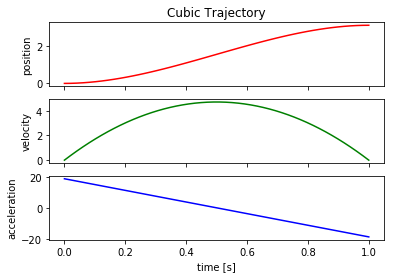

In [5]:
plot_trajectory(trajectories[0], iscubic=True)

## Quintic Polynomials

In [6]:
qi = [0,np.pi]
qf = [np.pi,0]
dqi = [0,0]
dqf = [0,0]
ddqi = [0,0]
ddqf = [0,0]
trajectories = quintic_trajectory(qi, qf, dqi, dqf, ddqi, ddqf, 50)

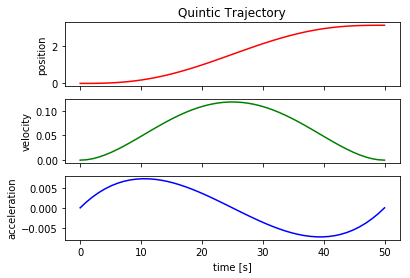

In [7]:
plot_trajectory(trajectories[0], iscubic=False)

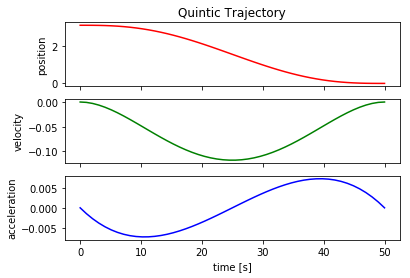

In [8]:
plot_trajectory(trajectories[1], iscubic=False)

## Linear segments with parabolic blends (LSPB)

In [207]:
traj = lspb_trajectory(0, np.pi, 1)

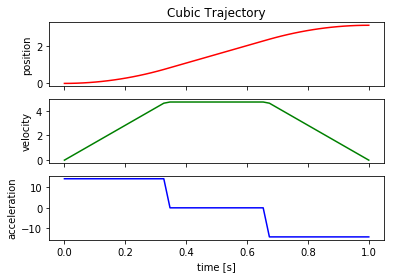

In [208]:
plot_trajectory(traj)

## 3D visualization of trajectories

In [212]:
vis = Kr6R900SixxVisualizer()

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='white', intensity=0.66, positi…

In [219]:
qi = [0,0,0,0,0,0]
qf = [-np.pi,-np.pi/2,0,np.pi/2,0,0]
dqi = [0,0,0,0,0,0]
dqf = [0,0,0,0,0,0]
ddqi = [0,0,0,0,0,0]
ddqf = [0,0,0,0,0,0]
traj = quintic_trajectory(qi, qf, dqi, dqf, ddqi, ddqf, 50)

In [220]:
for q in np.array([q for q, _, _, _ in traj]).T:
    vis.show(q, show_trajectory=True)
    time.sleep(0.05)

In [211]:
for q in np.array([lspb_trajectory(q1, q2, 2)[0] 
                   for q1, q2 in zip(qi, qf)]).T:
    vis.show(q)
    time.sleep(0.05)

# Operational space trajectories

In [221]:
q_home = [0, -np.pi/2, np.pi/2, 0, np.pi/2, 0]

In [222]:
vis = Kr6R900SixxVisualizer()
vis.show(q_home)

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='white', intensity=0.66, positi…

## Position

In [240]:
T0 = fk(q_home)[5]
p0 = T0[:3,3]
print(p0)

[0.445 0.    0.81 ]


In [241]:
Tf = T0.copy()
pf = Tf[:3,3]
pf += np.array([0, 0.4, -0.4]) # Add to y-axis
print(pf)

[0.445 0.4   0.41 ]


In [242]:
traj = cubic_trajectory(p0, pf, [0,0,0], [0,0,0], 1)

In [243]:
q = q_home
qs = []
Ts = []
for p in np.array([p for p, _, _, _ in traj]).T:
    T = T0.copy()
    T[:3,3] = p
    Ts.append(T)
    q = ik(T, fk, q)
    qs.append(q)

In [244]:
vis = Kr6R900SixxVisualizer()
vis.show(q_home)

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='white', intensity=0.66, positi…

In [245]:
for q in qs:
    vis.show(q, show_trajectory=True)

## Orientation

In [246]:
def exp(axis, angle):
    S = np.array([[0, -axis[2], axis[1]], 
                  [axis[2], 0, -axis[0]], 
                  [-axis[1], axis[0], 0]])
    return np.eye(3) + np.sin(angle) * S + (1 - np.cos(angle)) * S @ S

In [247]:
def aa(R):
    angle = np.arccos((np.trace(R) - 1)/2)
    axis = np.array([R[2,1] - R[1,2], 
                     R[0,2] - R[2,0], 
                     R[1,0] - R[0,1]]).reshape(3,1) / (2 * np.sin(angle))
    return axis, angle

In [248]:
T0

array([[ 1.   ,  0.   ,  0.   ,  0.445],
       [-0.   , -1.   ,  0.   ,  0.   ],
       [ 0.   , -0.   , -1.   ,  0.81 ],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])

In [249]:
Tf[:3,:3] = np.array([[0,0,1], 
                      [0,-1,0], 
                      [1,0,0]])
Tf

array([[ 0.   ,  0.   ,  1.   ,  0.445],
       [ 0.   , -1.   ,  0.   ,  0.4  ],
       [ 1.   ,  0.   ,  0.   ,  0.41 ],
       [ 0.   ,  0.   ,  0.   ,  1.   ]])

In [195]:
R0 = T0[:3,:3]
Rf = Tf[:3,:3]
R = R0.T @ Rf
print(R)

[[ 0.  0.  1.]
 [-0.  1.  0.]
 [-1. -0.  0.]]


In [197]:
axis, angle = aa(R)
print(axis)
print(angle)

[[-0.]
 [ 1.]
 [-0.]]
1.5707963267948966


In [184]:
exp(axis, angle)

array([[ 0.,  0.,  1.],
       [-0.,  1.,  0.],
       [-1., -0.,  0.]])

In [198]:
q = q_home
qs = []
Ts = []

ptraj = cubic_trajectory(p0, pf, [0,0,0], [0,0,0], 1)
ps = np.array([p for p, _, _, _ in ptraj]).T

atraj = cubic_trajectory([0], [angle], [0], [0], 1)
as_ = np.array([a for a, _, _, _ in atraj]).T

for p, a in zip(ps, as_):
    T = T0.copy()
    T[:3,3] = p
    T[:3,:3] = R0 @ exp(axis, a[0])
    Ts.append(T)
    q = ik(T, fk, q)
    qs.append(q)

In [201]:
vis = Kr6R900SixxVisualizer()
vis.show(q_home)

Renderer(camera=PerspectiveCamera(aspect=1.5, children=(DirectionalLight(color='white', intensity=0.66, positi…

In [202]:
for q in qs:
    vis.show(q, show_trajectory=True)